<a href="https://colab.research.google.com/github/venkatapranavi/feynnlabs-code/blob/main/AI_learning_path.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-Powered Personalized Learning Path Generator
**by saranya , pranavi**



This project builds a **personalized learning roadmap** for students or professionals based on:
- Learner profile (skills, goals, hours per week).
- Course catalog with metadata.
- Rule-based + AI-ready recommendation logic.

In [ ]:
!mkdir -p /content/ai_learning_path/src
!mkdir -p /content/ai_learning_path/data


In [ ]:
%%writefile /content/ai_learning_path/data/sample_catalog.csv
title,tags,level,hours
Intro to Python,"python,basics",beginner,10
Data Structures in C++,"c++,dsa",intermediate,15
Machine Learning 101,"ml,math,python",intermediate,20
Deep Learning Foundations,"ml,dl,python",advanced,25
System Design Basics,"system,design,architecture",advanced,20


Overwriting /content/ai_learning_path/data/sample_catalog.csv


In [ ]:
%%writefile /content/ai_learning_path/src/data_loader.py
import pandas as pd

def load_sample_catalog(path="/content/ai_learning_path/data/sample_catalog.csv"):
    return pd.read_csv(path)


Overwriting /content/ai_learning_path/src/data_loader.py


In [ ]:
%%writefile /content/ai_learning_path/src/learner_profile.py
from dataclasses import dataclass
from typing import List

@dataclass
class LearnerProfile:
    name: str = "Student"
    current_level: str = "beginner"     # beginner | intermediate | advanced
    target_role: str = "Software Engineer"
    goals: List[str] = None
    weak_skills: List[str] = None
    must_have_topics: List[str] = None
    available_hours_per_week: int = 10

    def __post_init__(self):
        if self.goals is None: self.goals = ["learn DSA", "prepare for interviews"]
        if self.weak_skills is None: self.weak_skills = ["dsa", "system"]
        if self.must_have_topics is None: self.must_have_topics = ["python", "c++"]


Overwriting /content/ai_learning_path/src/learner_profile.py


In [ ]:
%%writefile /content/ai_learning_path/src/skill_graph.py
import networkx as nx
import matplotlib.pyplot as plt

def get_prerequisites(skill: str):
    prereqs = {
        "dsa": ["python basics"],
        "ml": ["python basics", "math"],
        "dl": ["ml"]
    }
    return prereqs.get(skill, [])

def build_prereq_graph(target_skills):
    """
    Builds a prerequisite graph for given skills
    """
    G = nx.DiGraph()

    def add_with_prereqs(skill):
        if skill not in G:
            G.add_node(skill)
        for prereq in get_prerequisites(skill):
            G.add_edge(prereq, skill)  # prereq → skill
            add_with_prereqs(prereq)

    for s in target_skills:
        add_with_prereqs(s)

    return G

def plot_prereq_graph(G, title="Learning Path Prerequisite Graph"):
    """
    Visualizes the prerequisite graph
    """
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G, pos,
        with_labels=True,
        node_size=2500,
        node_color="lightblue",
        font_size=10,
        font_weight="bold",
        arrowsize=15
    )
    plt.title(title)
    plt.show()



Overwriting /content/ai_learning_path/src/skill_graph.py


In [ ]:
%%writefile /content/ai_learning_path/src/recommender.py
from dataclasses import dataclass
from typing import List
import pandas as pd
from src.learner_profile import LearnerProfile

@dataclass
class ScoredCourse:
    row: pd.Series
    score: float
    reasons: List[str]

def rank_courses(profile: LearnerProfile, catalog: pd.DataFrame, top_k: int = 10) -> List[ScoredCourse]:
    items = []
    for _, row in catalog.iterrows():
        score = 0.0
        reasons = []

        if any(skill in row.tags for skill in profile.weak_skills):
            score += 1.0
            reasons.append("matches weak skill")
        if profile.current_level == row.level:
            score += 0.5
            reasons.append("level aligned")

        if not reasons:
            reasons.append("generic match")

        items.append(ScoredCourse(row=row, score=score, reasons=reasons))

    return sorted(items, key=lambda x: x.score, reverse=True)[:top_k]


Overwriting /content/ai_learning_path/src/recommender.py


In [ ]:
%%writefile /content/ai_learning_path/src/planner.py
from dataclasses import dataclass
from typing import List
from src.recommender import ScoredCourse
from src.learner_profile import LearnerProfile

@dataclass
class WeeklyPlan:
    week: int
    title: str
    hours: int

def plan_path(profile: LearnerProfile, ranked: List[ScoredCourse]) -> List[WeeklyPlan]:
    weeks = []
    week_num = 1
    hours_left = profile.available_hours_per_week
    for sc in ranked:
        hrs = int(sc.row.hours)
        if hrs > hours_left:
            week_num += 1
            hours_left = profile.available_hours_per_week
        weeks.append(WeeklyPlan(week=week_num, title=sc.row.title, hours=hrs))
        hours_left -= hrs
    return weeks


Overwriting /content/ai_learning_path/src/planner.py


In [ ]:
%%writefile /content/ai_learning_path/src/visualize.py
import matplotlib.pyplot as plt
import networkx as nx
from src.planner import WeeklyPlan

def plot_plan(plan):
    # --- Bar chart ---
    weeks = [p.week for p in plan]
    titles = [p.title for p in plan]
    hours = [p.hours for p in plan]

    plt.figure(figsize=(8,4))
    plt.barh(titles, hours, color="skyblue", edgecolor="black")
    plt.xlabel("Hours")
    plt.ylabel("Courses")
    plt.title("Planned Learning Path (Weekly Hours)")
    plt.show()

def plot_graph(plan):
    # --- Graph representation using networkx ---
    G = nx.DiGraph()

    for p in plan:
        week_node = f"Week {p.week}"
        course_node = p.title
        G.add_node(week_node, type="week")
        G.add_node(course_node, type="course")
        G.add_edge(week_node, course_node, label=f"{p.hours}h")

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(8,6))
    node_colors = ["lightgreen" if G.nodes[n]["type"]=="week" else "lightblue" for n in G.nodes]
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color=node_colors, font_size=9, font_weight="bold")
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Learning Path Graph")
    plt.show()


Overwriting /content/ai_learning_path/src/visualize.py


In [ ]:
%%writefile /content/ai_learning_path/run.py
from src.data_loader import load_sample_catalog
from src.learner_profile import LearnerProfile
from src.recommender import rank_courses
from src.planner import plan_path
from src.visualize import plot_plan, plot_graph

def main():
    catalog = load_sample_catalog()
    profile = LearnerProfile()
    ranked = rank_courses(profile, catalog)
    plan = plan_path(profile, ranked)

    print("=== Recommendations ===")
    for r in ranked:
        print(f"- {r.row.title} ({r.score:.2f}) → {', '.join(r.reasons)}")

    print("\n=== Weekly Path ===")
    for p in plan:
        print(f"Week {p.week}: {p.title} — {p.hours}h")

    # Show graphs
    plot_plan(plan)   # bar chart
    plot_graph(plan)  # network graph

if __name__ == "__main__":
    main()


Overwriting /content/ai_learning_path/run.py


In [ ]:
!python /content/ai_learning_path/run.py


=== Recommendations ===
- Data Structures in C++ (1.00) → matches weak skill
- System Design Basics (1.00) → matches weak skill
- Intro to Python (0.50) → level aligned
- Machine Learning 101 (0.00) → generic match
- Deep Learning Foundations (0.00) → generic match

=== Weekly Path ===
Week 2: Data Structures in C++ — 15h
Week 3: System Design Basics — 20h
Week 4: Intro to Python — 10h
Week 5: Machine Learning 101 — 20h
Week 6: Deep Learning Foundations — 25h
Figure(800x400)
Figure(800x600)


=== Recommendations ===
- Data Structures in C++ (1.00) → matches weak skill
- System Design Basics (1.00) → matches weak skill
- Intro to Python (0.50) → level aligned
- Machine Learning 101 (0.00) → generic match
- Deep Learning Foundations (0.00) → generic match

=== Weekly Path ===
Week 2: Data Structures in C++ — 15h
Week 3: System Design Basics — 20h
Week 4: Intro to Python — 10h
Week 5: Machine Learning 101 — 20h
Week 6: Deep Learning Foundations — 25h


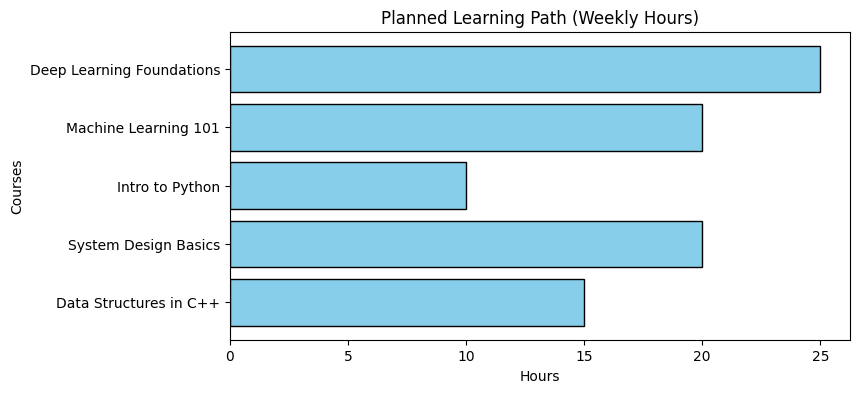

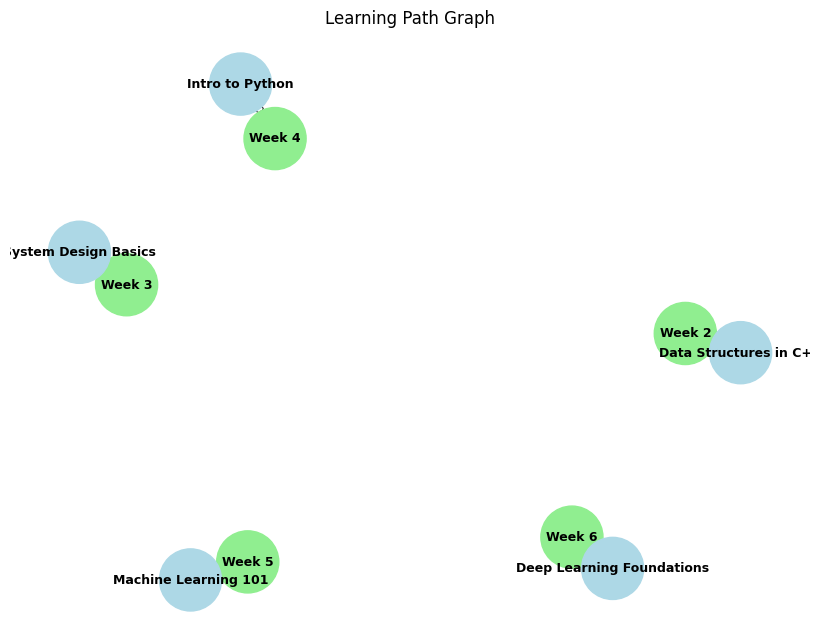

<Figure size 640x480 with 0 Axes>

In [ ]:
# Run main() directly inside notebook so matplotlib can display graphs
%run /content/ai_learning_path/run.py
